#### Import the dependencies

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from itertools import product

#### Read the training dataset

In [37]:
df = pd.read_csv('./CE802_P2_Data/CE802_P2_Data.csv')

#### Check the amount of rows

In [3]:
len(df)

1500

#### Move the class column to the first column

In [38]:
klass = df['Class']
df = df.drop(columns=['Class'])
df.insert(0, 'Class', klass)

#### Check missing null values

In [5]:
df.isnull().sum()

Class      0
F1         0
F2         0
F3         0
F4         0
F5         0
F6         0
F7         0
F8         0
F9         0
F10        0
F11        0
F12        0
F13        0
F14        0
F15      750
dtype: int64

#### Fill the values with the current median

In [39]:
df['F15'].fillna(df['F15'].median(), inplace = True)

In [7]:
df.isnull().sum()

Class    0
F1       0
F2       0
F3       0
F4       0
F5       0
F6       0
F7       0
F8       0
F9       0
F10      0
F11      0
F12      0
F13      0
F14      0
F15      0
dtype: int64

#### Check which features are discrete

In [8]:
for column in df.columns:
    print(column, len(df[column].unique()))

Class 2
F1 656
F2 432
F3 141
F4 650
F5 4
F6 214
F7 660
F8 91
F9 400
F10 649
F11 646
F12 11
F13 216
F14 80
F15 331


Based on this data, I'm thinking that the best would be to consider those features which amount of unique values are less than 100. Mainly because I want to have few values as discrete. This results in the following features as being discrete:

- F5
- F8
- F12
- F14

#### Quick analysis of correlation of features and class

<AxesSubplot:>

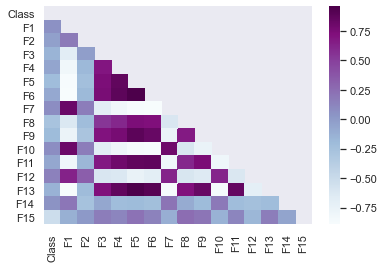

In [9]:
sns.set_theme()
# Compute the correlation matrix
corr_all = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask, cmap = "BuPu")

Seems like the maybe the best columns to check will be:

- F1
- F7
- F10
- F12
- F14

This will help to reduce the complexity while also having those variables that seems correlated with the class column

#### Preprocessing

For this it's more about the creation of datasets for training and testing, while also performing some preparation of it

In [10]:
corr_cols = ['F1', 'F7', 'F10', 'F12', 'F14']
bayes_cols = ['F5', 'F8', 'F12', 'F14']
def preprocess(all_columns=True, cols=None):
    df['Class'] = df['Class'].astype(int)
    x_cols = df.columns[1:] if all_columns else corr_cols if cols is None else cols
    X, Y = df[x_cols], df['Class']
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
    return (x_train, y_train), (x_test, y_test)

corr_preprocess = lambda: preprocess(False)
bayes_preprocess = lambda: preprocess(False, bayes_cols)

## Check the performance

#### Create function to permurate params
What this function will do is the following

1. Create all the combination of the possible parameters values given to the function.Ex.

`params = [[1, 2], [4, 5]] -> products = [(1, 4), (1, 5), (2, 4), (2, 5)]`

2. Evaluate each of the products using the builder function. _Note. All the builders will return a score, in this case the score is the mean accuracy of the model_
3. Based on the prior evaluation, we will see which is the argmax and return the score and params used

In [11]:
def permutate_params(builder, params, current_params=None):
    products = list(product(*params))
    scores = list(map(builder, products))
    max_index = np.argmax(scores)
    return scores[max_index], products[max_index]

#### Get training and testing datasets

In [12]:
training, testing = preprocess()

### DecisionTreeClassifier

#### Create builder function

As shown below in this case we will create a `DecisionTreeClassifier` using as hyperparameters to tune the following parameters

- max_depth
- min_samples_split
- max_features

In [13]:
def build_tree(values):
    max_depth, min_samples_split, max_features = values 
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        max_features=max_features
    )
    clf.fit(training[0], training[1])
    return clf.score(testing[0], testing[1])

#### Add parameter values to experiment with

In [14]:
max_depths = [2, 8, 64, 256]
min_samples_splits = [2, 4, 8]
max_features = ['sqrt', 'log2', None]

#### Check which is the best permutation

In [15]:
score, best_params = permutate_params(build_tree, [max_depths, min_samples_splits, max_features])

print('Best params', best_params)
print('Best Score', score)

Best params (8, 2, None)
Best Score 0.7977777777777778


### SVMs

#### Create builder function

As shown below in this case we will create a `SVC` using as hyperparameters to tune the following parameters

- C
- kernel
- gamma

In [16]:
def build_svm(values):
    C, kernel, gamma = values
    clf = SVC(C=C, kernel=kernel, gamma=gamma)
    clf.fit(training[0], training[1])
    return clf.score(testing[0], testing[1])

In [17]:
cs = [0.5, 1, 2, 4]
kernels = ['poly', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']

In [18]:
score, best_params = permutate_params(build_svm, [cs, kernels, gammas])

print('Best params', best_params)
print('Best Score', score)

Best params (4, 'poly', 'scale')
Best Score 0.8955555555555555


### Neural Networks

#### Create builder function

This builder function is the must complicated of all. The overall objective of the builder is to create a function that creates a MLP Neural Network that consists of **3 hidden layers**.

The main difference with the other builders is that the parameters received for the builder are actually an array consisting of tuples of parameters. As each of this tuples are the parameters that each of the layers may have, in this case being the amount of units per layer and the activation function.

In [19]:
inputs_num = training[0].shape[1]
input_shape = (inputs_num,)
def build_nn(values):
    model = Sequential()
    for index, layer_params in enumerate(values):
        units, activation = layer_params
        if index == 0:
            model.add(Dense(units, activation=activation, input_shape=input_shape))
        else:
            model.add(Dense(units, activation=activation))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer='Adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    history = model.fit(
        training[0],
        training[1],
        validation_data=testing,
        epochs=50,
        verbose=0).history
    return history['val_accuracy'][-1]

In [20]:
layer_products = list(product([5, 10, 20, 50], ['tanh', 'relu', 'sigmoid']))

In [22]:
best_params, best_score = [], 0

for params in list(product(layer_products, layer_products, layer_products)):
    score = build_nn(params)
    if score > best_score:
        best_params = params
        best_score = score

print('Best params', best_params)
print('Best Score', best_score)

Best params ((50, 'relu'), (50, 'relu'), (50, 'relu'))
Best Score 0.8733333349227905


## Check the performance (correlation features)

In [23]:
training, testing = corr_preprocess()

After this we will reuse the same code for obtaining the best score and permutation as above, being the only difference the training and testing datasets used

In [24]:
score, best_params = permutate_params(build_tree, [max_depths, min_samples_splits, max_features])

print('Best params', best_params)
print('Best Score', score)

Best params (8, 8, 'sqrt')
Best Score 0.6711111111111111


In [25]:
score, best_params = permutate_params(build_svm, [cs, kernels, gammas])

print('Best params', best_params)
print('Best Score', score)

Best params (0.5, 'rbf', 'scale')
Best Score 0.6711111111111111


In [27]:
best_params, best_score = [], 0
inputs_num = training[0].shape[1]
input_shape = (inputs_num,)

for params in list(product(layer_products, layer_products, layer_products)):
    score = build_nn(params)
    if score > best_score:
        best_params = params
        best_score = score

print('Best params', best_params)
print('Best Score', best_score)

Best params ((50, 'relu'), (50, 'relu'), (5, 'relu'))
Best Score 0.6755555272102356


## Categorical Naive-Bayes

Contrary to the other models we will not be testing with other values, because there were not a lot of values to experiment with

In [28]:
training, testing = bayes_preprocess()
clf = CategoricalNB()
clf.fit(training[0], training[1])
clf.score(testing[0], testing[1])

0.6177777777777778

## Predict test dataset

Based on the results above, the best model that we obtained was the SVC model using all the data, the following scripts will be used to predict the class of the test dataset using the mentioned model

In [40]:
training, testing = preprocess()
df = pd.read_csv('./CE802_P2_Data/CE802_P2_Test.csv')
df.isnull().sum()

F1          0
F2          0
F3          0
F4          0
F5          0
F6          0
F7          0
F8          0
F9          0
F10         0
F11         0
F12         0
F13         0
F14         0
F15       750
Class    1500
dtype: int64

In [41]:
df['F15'].fillna(df['F15'].median(), inplace = True)

In [42]:
x_cols = df.columns[:-1]
X = df[x_cols]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [43]:
C, kernel, gamma = (4, 'poly', 'scale')
clf = SVC(C=C, kernel=kernel, gamma=gamma)
clf.fit(training[0], training[1])

SVC(C=4, kernel='poly')

In [44]:
df['Class'] = clf.predict(X)
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,3.54,0.45,600,2.16,20,33.86,-4.16,207.86,8.30,6.64,-17.68,-36.32,16.80,-49.14,-6.810,0
1,12.96,4.50,6,-5.42,2,21.22,-0.66,115.86,1.95,10.19,-24.32,-21.32,0.06,-229.14,-7.100,0
2,13.02,2.74,81,-7.08,2,21.28,1.40,111.86,2.05,11.30,-34.98,-21.32,0.42,-217.14,-7.050,0
3,14.91,1.00,162,-8.30,2,21.12,-0.42,85.86,0.96,10.16,-24.68,-25.32,0.42,-202.14,-7.775,0
4,2.61,1.46,1020,4.66,20,30.66,-0.46,122.86,7.20,7.04,-16.86,-26.32,20.25,-289.14,-7.775,0


In [46]:
df.to_csv('./CE802_P2_Data/CE802_P2_Test.csv', index=False)